# Parallel Computing 1: iPyParallel
    Name

In [1]:
from ipyparallel import Client
import numpy as np
import time
from matplotlib import pyplot as plt
import scipy.stats as stats

In [2]:
%matplotlib inline

## Problem 1
Initializes a `Client` object, create a `DirectView` with all available engines, and import `scipy.sparse` as `sparse` on all engines.

(This is just to make sure your cluster is running and connected correctly)

In [3]:
# initialize client
client = Client()

# create directview
dview = client[:]

# import scipy.sparse as sparse
dview.execute("import scipy.sparse as sparse")

<AsyncResult: execute>

## Problem 2

Write a function `variables(dx)` that accepts a dictionary of variables.
Distribute the variables to all engines, then pull the variables back.

In [4]:
def variables(dx):
    """
    input: dx, dictionary of variables
    
    tasks: push variables to all engines
           (from the problem 1 client)
           pull variables back and check them
               against the original dictionary
    """
    # push values to each engine
    dview.push(dx)

    # iterate through each item
    for x,val in dx.items():
        
        # Pull the values from each engine
        vals = dview[x]
        # Ensure that each value is what it should be
        if not np.all([v == val for v  in vals]):
            # If anything is out of place, return false
            return False
    
    # if everything matches like it should, return true
    return True
    


In [5]:
# run something to check your function
dx = {'a':1,'b':2}

# Variables
variables(dx)

True

## Problem 3

Write a function that accepts an integer n.
Instruct each engine to make n draws from the standard normal distribution, then hand back the minimum, maximum, and mean draw to the client.
Print the results.

In [6]:
dview.execute('import numpy as np')

<AsyncResult: execute>

In [7]:
def get_stats(n):
    # take n draws
    draws = np.random.randn(n)
    
    # return min, max, mean
    return draws.min(), draws.max(), draws.mean()

def draw_statistics(n):
    """
    input: integer n
    
    tasks: each engine makes n draws from 
            standard normal distribution
           compute the min, max, and mean for
            each engine
           print the resulting lists of mins,
            maxs, and means
    """
    results = dview.apply(get_stats,n)
    mins = [m[0] for m in results]
    maxs = [m[1] for m in results]
    means = [m[2] for m in results]
    return mins, means, maxs

    


In [8]:
# run something to check your function
mins, means, maxs = draw_statistics(10)
print("means =",means)
print("maxs =", maxs)
print("mins =",mins)


means = [0.07377322627240158, 0.6129350252873231, -0.015122270549820821, 0.539141992528126, -0.11328733222752374, 0.7121035094379015]
maxs = [1.594462360794884, 2.1883485834456065, 1.7154942913131352, 1.8249779461934832, 1.8379491181674552, 1.573760841253193]
mins = [-1.3276744389709496, -1.6497038981155643, -1.285593967281482, -0.6080915804615024, -2.625486286572803, -0.9224445139986078]


## Problem 4

Use `draw_statistics()` to compare serial and parallel execution times.
For $n = 1000000, 5000000, 10000000, 15000000,$
1. Time how long it takes to run your function.
2. Time how long it takes to do the same process (make n draws and calculate and record the statistics) in a for loop with $N$ iterations, where $N$ is the number of engines running.

Plot the execution times against $n$.
You should notice an increase in efficiency in the parallel
version as the problem size increases.

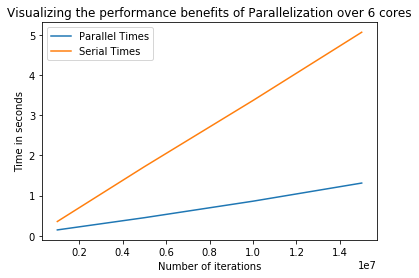

In [19]:
# for each n value
ns = (np.array([1,5,10,15])*1e6).astype(int)

serial_times = []
parallel_times = []
for n in ns:
    
    # time how long it takes to run draw_statistics
    start = time.time()
    draw_statistics(n)
    total = time.time() - start
    
    # store these times
    parallel_times.append(total)

    # if there are N engines, time how long it takes to run draw_statistics N times
    start = time.time()
    for _ in range(len(client.ids)):
        get_stats(n)
    total = time.time() - start
    
    # store these times
    serial_times.append(total)

# plot the two lists of times
plt.plot(ns, parallel_times, label="Parallel Times")
plt.plot(ns, serial_times, label="Serial Times")
plt.title("Visualizing the performance benefits of Parallelization over {} cores".format(len(client.ids)))
plt.xlabel("Number of iterations")
plt.ylabel("Time in seconds")
plt.legend()
plt.show()

## Problem 5

Write a function that accepts a function handle $f$ to integrate, bounds of integration, and the number of points to use for the approximation.
Parallelize the trapezoid rule in order to estimate the integral of $f$ over the given bounds.
That is, evenly divide the points among all available processors and run the trapezoid rule on each portion simultaneously.
The sum of the results of all the processors will be the estimation of the integral over the entire interval of integration.
Return this sum.

Demonstrate that your function works.

In [26]:
def trapezoid_parallel(f, a, b, N):
    """
    inputs: f = func to integrate
            a,b = integration bounds
            N = number of points used
    tasks:  estimate integral of f
    """
    # Lay out N points between a and b
    h = (b - a)/ (N - 1)
    points = np.linspace(a,b,N)
    
    # Tell the controller to split up the work however works best
    sum_points = lambda a,b: f(a) + f(b)
    results = dview.map(sum_points,points[:-1],points[1:])
 
    # multiply by h/2 for each section, return integral estimate
    return h/2 * sum(results)
    

In [27]:
# test f
f = lambda x: np.sin(x) + 4
a,b = 1,4
N = 40

# evaluate integral using your function
print('estimated integral:',trapezoid_parallel(f,a,b,N))

# compare to scipy result
import scipy.integrate as integrate
print('actual integral:',integrate.quad(f,a,b)[0])

estimated integral: 13.19335713793024
actual integral: 13.193945926731752
